In [1]:
# SVR Model for Traffic Volume Prediction
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math


In [2]:
# Load dataset
df = pd.read_csv("SData_Oct2006.csv", header=1)

# Extract and flatten V1–V94 traffic volume columns
v_columns = [col for col in df.columns if col.startswith('V') and col[1:].isdigit()]
traffic_data = df[v_columns].values.flatten()
traffic_data = traffic_data[~np.isnan(traffic_data)].reshape(-1, 1)


In [3]:
# Normalize using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(traffic_data)


In [4]:
# Create time series sequences for SVR
SEQ_LEN = 10
X, y = [], []
for i in range(len(scaled_data) - SEQ_LEN):
    X.append(scaled_data[i:i + SEQ_LEN].flatten())
    y.append(scaled_data[i + SEQ_LEN])
X = np.array(X)
y = np.array(y)


In [5]:
# 80/20 train-test split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [6]:
# Train SVR with simulated epoch-like feedback
from sklearn.utils import shuffle

svr = SVR(kernel='rbf')
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)
chunks = np.array_split(np.arange(len(X_train_shuffled)), 10)

print("Simulated SVR Training:")
for epoch, idx in enumerate(chunks, start=1):
    svr.fit(X_train_shuffled[idx], y_train_shuffled[idx].ravel())
    y_pred_partial = svr.predict(X_train_shuffled[idx])
    loss = mean_squared_error(y_train_shuffled[idx], y_pred_partial)
    print(f"Epoch {epoch}/10, Loss: {loss:.4f}")


Simulated SVR Training:
Epoch 1/10, Loss: 0.0024
Epoch 2/10, Loss: 0.0014
Epoch 3/10, Loss: 0.0022
Epoch 4/10, Loss: 0.0022
Epoch 5/10, Loss: 0.0016
Epoch 6/10, Loss: 0.0022
Epoch 7/10, Loss: 0.0015
Epoch 8/10, Loss: 0.0019
Epoch 9/10, Loss: 0.0021
Epoch 10/10, Loss: 0.0019


In [7]:
# Evaluate on test data
y_pred = svr.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = math.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 24.47
RMSE: 29.09


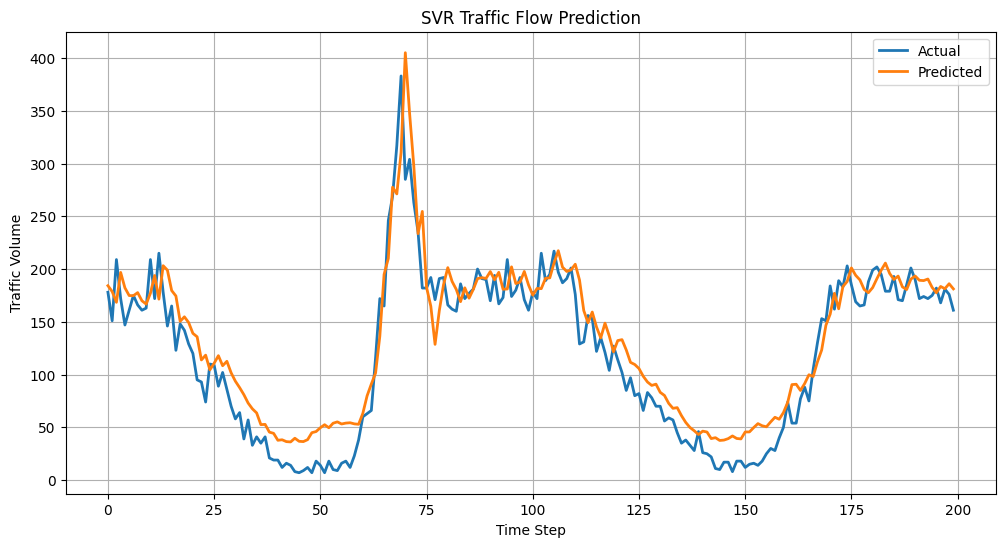

In [8]:
# Plot prediction results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:200], label='Actual', linewidth=2)
plt.plot(y_pred_rescaled[:200], label='Predicted', linewidth=2)
plt.title('SVR Traffic Flow Prediction')
plt.xlabel('Time Step')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(True)
plt.show()
